In [4]:
!pip install seaborn

In [27]:
!pip install nltk


In [6]:
!pip install nltk


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   --------------------------- ------------ 1.0/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.2 MB/s eta 0:00:00


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
import string

In [8]:
# Télécharger les stopwords de NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Charger les données
file_path = "final_dataset.csv"  # Remplacez par le chemin de votre fichier
df = pd.read_csv(file_path)

In [11]:
print(df.head())

    title  rating                                            content  \
0  Helix–       5  commande bien reçu merci pour votre profession...   
1  Helix–       4  Je suis très impressionnée par la qualité de c...   
2  Helix–       5  kthit menou lel khedma ihezli pc o les documen...   
3  Helix–       4  wselni le sac à dos je suis satisfait la quali...   
4  Helix–       5  Très pratique, surtout pour transporter mon or...   

                                     cleaned_content sentiment  
0  commande bien reçu merci pour votre profession...  positive  
1  je suis très impressionnée par la qualité de c...  positive  
2  kthit menou lel khedma ihezli pc le document f...  positive  
3  wselni le sac à do je suis satisfait la qualit...  positive  
4  très pratique surtout pour transporter mon ord...  positive  


In [12]:
# Prétraitement des données
def preprocess_text(text):
    text = text.lower()  # Convertir en minuscules
    text = ''.join([char for char in text if char not in string.punctuation])  # Supprimer la ponctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Supprimer les stopwords
    return text

In [13]:
df['cleaned_content'] = df['content'].apply(preprocess_text)

In [14]:
# Vérification des données nettoyées
print(df[['content', 'cleaned_content']].head())

                                             content  \
0  commande bien reçu merci pour votre profession...   
1  Je suis très impressionnée par la qualité de c...   
2  kthit menou lel khedma ihezli pc o les documen...   
3  wselni le sac à dos je suis satisfait la quali...   
4  Très pratique, surtout pour transporter mon or...   

                                     cleaned_content  
0  commande bien reçu merci professionnalisme com...  
1  très impressionnée qualité sac tissu étanche p...  
2  kthit menou lel khedma ihezli pc o documents f...  
3        wselni sac dos satisfait qualité excellente  
4  très pratique surtout transporter ordinateur t...  


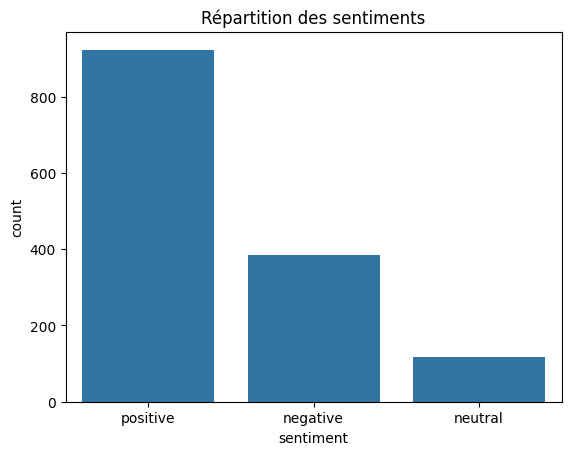

In [15]:
# Distribution des sentiments
sns.countplot(data=df, x='sentiment')
plt.title('Répartition des sentiments')
plt.show()

In [16]:
# Séparer les données en features et labels
X = df['cleaned_content']
y = df['sentiment']

In [17]:
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Vectorisation avec TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [19]:
# Modèle de classification avec Naive Bayes
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [20]:
# Prédiction
y_pred = model.predict(X_test_tfidf)

In [21]:
# Évaluation du modèle
print("Rapport de classification :\n", classification_report(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Précision : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Rapport de classification :
               precision    recall  f1-score   support

    negative       1.00      0.34      0.51        85
     neutral       1.00      1.00      1.00        28
    positive       0.75      1.00      0.86       172

    accuracy                           0.80       285
   macro avg       0.92      0.78      0.79       285
weighted avg       0.85      0.80      0.77       285

Matrice de confusion :
 [[ 29   0  56]
 [  0  28   0]
 [  0   0 172]]
Précision : 80.35%


In [22]:
# Tester avec un exemple
example = ["lahkika excellent, 3jebni."]
example_cleaned = [preprocess_text(example[0])]
example_tfidf = tfidf.transform(example_cleaned)
prediction = model.predict(example_tfidf)
print("Sentiment prédit :", prediction[0])

Sentiment prédit : positive


In [24]:
from sklearn.preprocessing import LabelBinarizer

# --- Calcul des courbes ROC et AUC ---
# Binariser les labels pour la courbe ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]



In [31]:
print(y_test.shape)  # Devrait être (n_samples,)
print(y_pred_prob.shape)  # Devrait être (n_samples,)


(285,)
(285,)


In [32]:
print(set(y_test))  # Devrait afficher {0, 1} pour une classification binaire


{'neutral', 'negative', 'positive'}


In [35]:
# Binariser les labels pour la courbe ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)[:, 0]  # Assurez-vous d'avoir une seule colonne de 0 et 1


In [36]:
# Vérifier les dimensions
print(f"y_test_bin shape: {y_test_bin.shape}")
print(f"y_pred_prob shape: {y_pred_prob.shape}")


y_test_bin shape: (285,)
y_pred_prob shape: (285,)


In [37]:
 #Prédire les probabilités pour la classe 1
y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]

In [38]:
# Calcul des courbes ROC et AUC
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

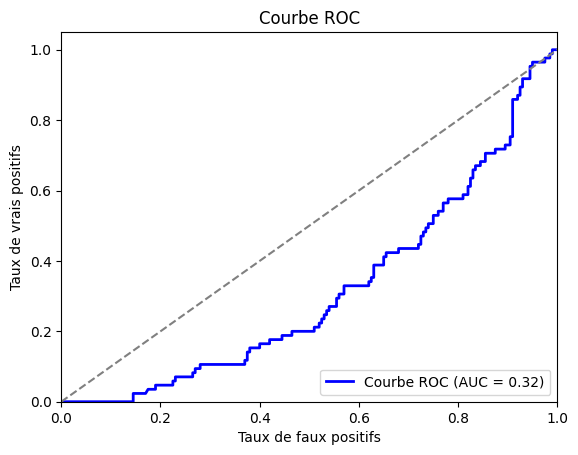

In [39]:
# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [42]:
from sklearn.metrics import precision_recall_curve
# --- Calcul et affichage de la courbe de précision/rappel ---
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_prob)

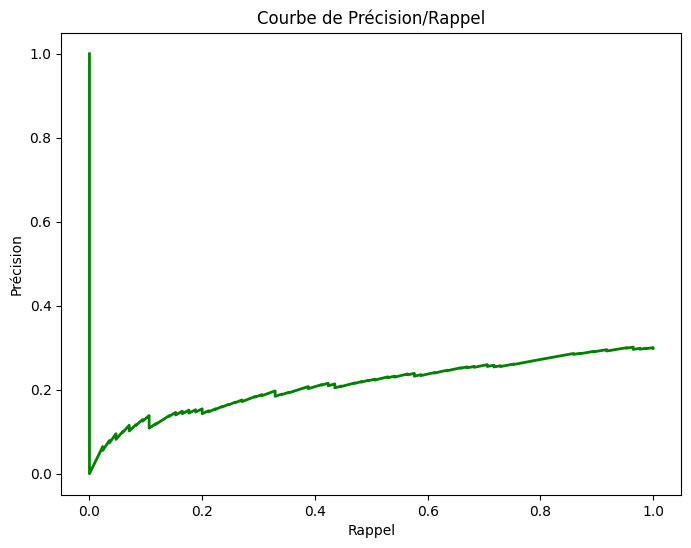

In [43]:
# Affichage de la courbe de précision/rappel
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.title('Courbe de Précision/Rappel')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.show()

In [44]:
# Test avec un exemple
example = ["Ce produit est vraiment excellent, je le recommande fortement."]
example_cleaned = [preprocess_text(example[0])]
example_tfidf = tfidf.transform(example_cleaned)
prediction = model.predict(example_tfidf)
print("Sentiment prédit :", prediction[0])

Sentiment prédit : positive


                                             content  content_length
0  commande bien reçu merci pour votre profession...              85
1  Je suis très impressionnée par la qualité de c...             155
2  kthit menou lel khedma ihezli pc o les documen...              79
3  wselni le sac à dos je suis satisfait la quali...              63
4  Très pratique, surtout pour transporter mon or...             129


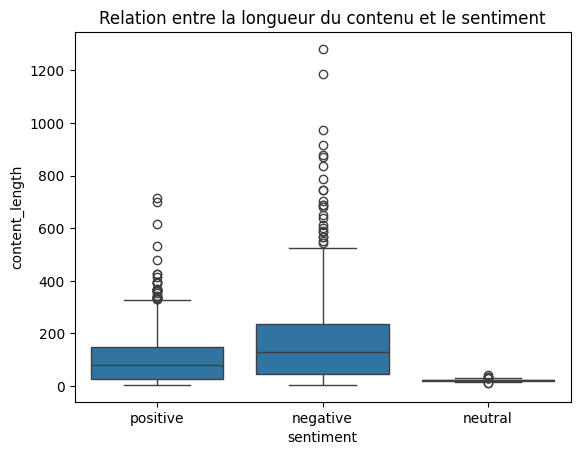

In [47]:
# Ajouter la colonne content_length (longueur du texte dans 'content')
df['content_length'] = df['content'].apply(len)

# Afficher un aperçu des données avec la nouvelle colonne
print(df[['content', 'content_length']].head())

# Visualisation de la relation entre la longueur du contenu et le sentiment
sns.boxplot(data=df, x='sentiment', y='content_length')  # Utiliser la colonne 'content_length'
plt.title('Relation entre la longueur du contenu et le sentiment')
plt.show()

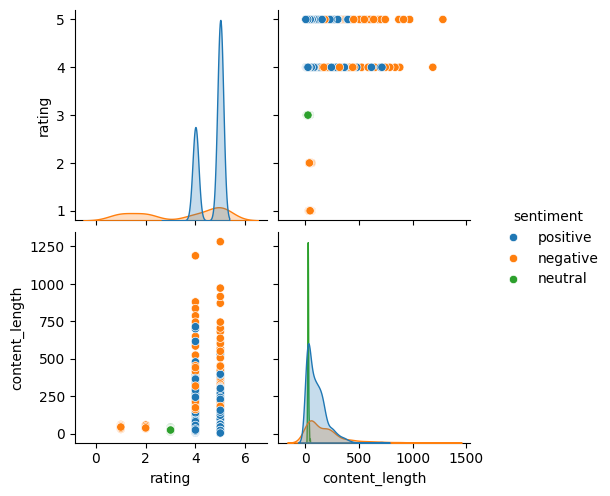

In [48]:
# Vous pouvez également visualiser des nuages de points pour des caractéristiques numériques
sns.pairplot(df, hue='sentiment')
plt.show()

In [49]:
# Entraînement du modèle avec la régression logistique
from sklearn.linear_model import LogisticRegression

# Entraînement du modèle
model = LogisticRegression(max_iter=1000)  # Vous pouvez ajuster max_iter selon les besoins
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [50]:
#  Prédiction des classes sur l'ensemble de test
y_pred = model.predict(X_test_tfidf)

#  Affichage des classes attribuées par le modèle
print("Classes attribuées par le modèle :\n", y_pred)

Classes attribuées par le modèle :
 ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'positive' 'negative' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'negative' 'positive'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'negative' 'positive' 'positive' 'positive' 'neutral' 'positive'
 'positive' 'positive' 'positive' 'negative' 'negative' 'neutral'
 'negative' 'neutral' 'positive' 'negative' 'positive' 'neutral'
 'positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive' 'negative' 'positive' 'negative' 'positive' 'positive'
 'neutral' 'negative' 'positive' 'positive' 'negative' 'positive'
 'positive' 'positive' 'positive' 'negative' 'positive' 'positive'
 'positive' 'positive' 'neutral' 'negative' 'positive' 'positive'
 'positive' 'neutral' 'negative' 'positive' 'neutral' 'positive'
 'positive' 'positive' 'positive' 

In [51]:
#  Visualisation des classes attribuées avec un scatter plot
# Réduction de la dimensionnalité pour la visualisation avec PCA
from sklearn.decomposition import PCA

# Réduction de la dimensionnalité à 2 dimensions pour une visualisation 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_test_tfidf.toarray())

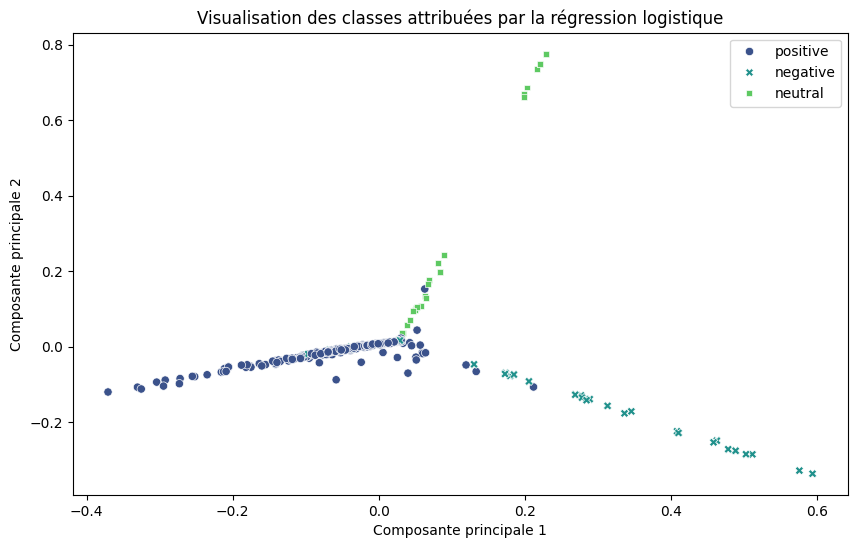

In [52]:
# Visualisation avec un scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y_pred, palette='viridis', style=y_pred)
plt.title('Visualisation des classes attribuées par la régression logistique')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

In [53]:
# Évaluation du modèle
print("Rapport de classification :\n", classification_report(y_test, y_pred))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Précision : {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Rapport de classification :
               precision    recall  f1-score   support

    negative       0.92      0.39      0.55        85
     neutral       1.00      0.93      0.96        28
    positive       0.76      0.98      0.86       172

    accuracy                           0.80       285
   macro avg       0.89      0.77      0.79       285
weighted avg       0.83      0.80      0.77       285

Matrice de confusion :
 [[ 33   0  52]
 [  0  26   2]
 [  3   0 169]]
Précision : 80.00%


In [55]:
text_to_test = [
    "Très bon produit, je vais en acheter un autre.",  # Positif
    "khayeb service client.",  # Négatif
    "Le produit est arrivé en bon état mais je m'attendais à mieux.",  # Neutre
    "Le produit tayer .",  # Positif
    "mch farhan.",  # Négatif
]
# Appliquer le prétraitement aux textes à tester
X_test_clean = [preprocess_text(text) for text in text_to_test]

# Convertir les textes prétraités en TF-IDF
X_test_tfidf = tfidf.transform(X_test_clean)

# Prédiction des sentiments
y_pred_test = model.predict(X_test_tfidf)

# Affichage des résultats
for text, prediction in zip(text_to_test, y_pred_test):
    print(f"Texte : {text}")
    print(f"Sentiment prédit : {prediction}\n")

Texte : Très bon produit, je vais en acheter un autre.
Sentiment prédit : positive

Texte : khayeb service client.
Sentiment prédit : negative

Texte : Le produit est arrivé en bon état mais je m'attendais à mieux.
Sentiment prédit : positive

Texte : Le produit tayer .
Sentiment prédit : positive

Texte : mch farhan.
Sentiment prédit : neutral

